# **`Topic Modeling using BERT`**

Reference paper--Angelov, D. (2020).Top2Vec: Distributed Representations of Topics. arXiv preprint arXiv:2008.09470.

**Objective: To extract important topics from news data with around 19000 sentences**

***Approach:   Create Embeddings{BERT] ---> Dimensionality reduction[UMAP] --> Clustering[HDBSCAN] --> Topic Creation[Class tf-idf-] --> Extract top words***

In [ ]:
!pip install sentence-transformers
!pip install umap-learn
import umap
from sklearn.datasets import fetch_20newsgroups
from sentence_transformers import SentenceTransformer

In [ ]:
data = fetch_20newsgroups(subset='all')['data']

In [4]:
len(data)

18846

# Word embeddings using BERT

In [5]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)

100%|██████████| 245M/245M [00:11<00:00, 21.4MB/s]


In [6]:
len(embeddings)

18846

#Clustering

Reduce vector size before clustering to improve clustering performance--use UMAP( it keeps major info intact)

In [7]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

Clustering using HDBSCAN

In [ ]:
!pip install hdbscan
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

Visualize clusters by reducing dim to 2 and pointing outliers

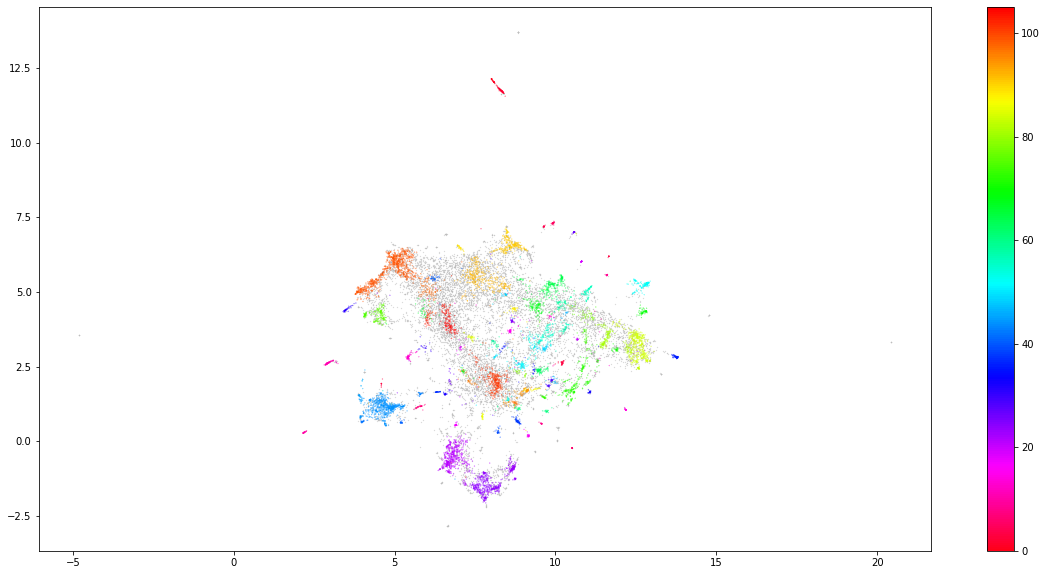

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

# Topic Creation
Treat all docs in a single cluster as one doc and apply class tf-idf

In [11]:
# create single doc for each cluster
import pandas as pd
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [12]:
# Apply c-tf idf
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))


# Topic representation

In [13]:
# top 20 words per topic based on their c-TF-IDF scores.
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,10598
100,99,851
45,44,663
22,21,549
25,24,437
85,84,424
93,92,327
102,101,276
92,91,240
73,72,223


Topics 7, 43, 12, and 41 are the largest clusters that we could create. We fetch top 20 words 

In [25]:
# Top n words
# Topic 43 tells about fire in a building
top_n_words[43][:10]

[('fbi', 0.03734214322489433),
 ('atf', 0.03668092167253831),
 ('dividian', 0.03132739140293555),
 ('survivors', 0.031160137451108218),
 ('burns', 0.03088946299801106),
 ('ranch', 0.030732884591384197),
 ('burning', 0.020287609708113555),
 ('compound', 0.01826062431475471),
 ('fires', 0.018102950311964832),
 ('building', 0.016092985407854577)]

In [18]:
# Topic 41 tells about crime
top_n_words[41][:10]

[('gun', 0.03229310526821338),
 ('guns', 0.018940461852994184),
 ('militia', 0.01738889827990427),
 ('weapons', 0.013225000775266367),
 ('weapon', 0.012427275434333208),
 ('control', 0.0106875848316847),
 ('firearm', 0.010534965057995699),
 ('manes', 0.010334989707748632),
 ('crime', 0.009699265035351744),
 ('revolver', 0.009508072272664734)]

# Topic merging
Merge similar topics together based on cosine similarity

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,10598
81,80,851
33,32,663
15,14,567
17,16,452
67,66,443
75,74,376
82,81,292
74,73,240
50,49,228


We reduce 56 topics to 36 by keeping information intact 